In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model, Sequential, save_model, model_from_json, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
print("Training set:")
for ges in os.listdir("/content/drive/My Drive/mask-detection/"):
    print(str(len(os.listdir("/content/drive/My Drive/mask-detection/"+ges))),ges,"images.")

Training set:
690 Mask images.
686 No Mask images.


In [ ]:
img_size = 256
batch_size = 32

In [ ]:
data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=0.4,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    shear_range=0.2,
                                    zoom_range=0.3,
                                    fill_mode="nearest",
                                    validation_split=0.2,
                                    horizontal_flip=True)

train_gen = data_gen.flow_from_directory("/content/drive/My Drive/mask-detection/",
                                              target_size=(img_size,img_size),
                                              batch_size=batch_size,
                                              color_mode="rgb",
                                              class_mode="binary",
                                              shuffle=True,
                                              subset='training')

val_gen = data_gen.flow_from_directory("/content/drive/My Drive/mask-detection/",
                                              target_size=(img_size,img_size),
                                              batch_size=batch_size,
                                              color_mode="rgb",
                                              class_mode="binary",
                                              subset='validation')

Found 1101 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


In [ ]:
model = Sequential(
        [
            Conv2D(64,3,activation='relu',input_shape=(img_size,img_size,3)),
            MaxPooling2D(pool_size=(2,2)),
            BatchNormalization(),
            Conv2D(128,3,activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Flatten(),
            Dropout(0.2),
            Dense(256,activation='relu'),
            Dense(1,activation='sigmoid'),
        ])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 492032)            0         
_________________________________________________________________
dropout (Dropout)            (None, 492032)            0

In [ ]:
r = model.fit(train_gen, epochs=20, validation_data=val_gen)

Epoch 1/20
35/35 [==============================] - 661s 19s/step - loss: 14.8559 - accuracy: 0.6857 - val_loss: 0.6923 - val_accuracy: 0.7091
Epoch 2/20
35/35 [==============================] - 26s 749ms/step - loss: 1.8916 - accuracy: 0.7766 - val_loss: 0.6720 - val_accuracy: 0.5745
Epoch 3/20
35/35 [==============================] - 26s 734ms/step - loss: 0.6584 - accuracy: 0.8420 - val_loss: 0.6942 - val_accuracy: 0.4945
Epoch 4/20
35/35 [==============================] - 26s 744ms/step - loss: 0.3541 - accuracy: 0.8728 - val_loss: 0.6952 - val_accuracy: 0.4982
Epoch 5/20
35/35 [==============================] - 26s 735ms/step - loss: 0.2946 - accuracy: 0.8792 - val_loss: 0.8390 - val_accuracy: 0.4982
Epoch 6/20
35/35 [==============================] - 26s 752ms/step - loss: 0.2277 - accuracy: 0.9155 - val_loss: 0.7770 - val_accuracy: 0.4982
Epoch 7/20
35/35 [==============================] - 26s 743ms/step - loss: 0.3240 - accuracy: 0.8747 - val_loss: 1.0307 - val_accuracy: 0.4982

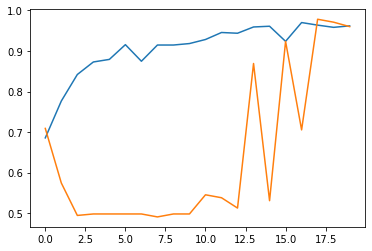

In [ ]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.show()

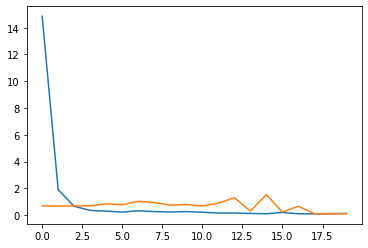

In [ ]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.show()

In [ ]:
model.save("mask_detection_model.h5")

In [ ]:
rps_model_json = model.to_json()
with open("mask_detection_architecture.json", "w") as json_file:
    json_file.write(rps_model_json)
# saving the model weight separately
model.save_weights("mask_detection_weights.h5")

New session:

In [ ]:
model = load_model('/content/drive/My Drive/mask_detection_model.h5')

In [ ]:
train_gen.class_indices

{'Mask': 0, 'No Mask': 1}

In [ ]:
classes = train_gen.class_indices
mapper_dict = {value: key for key,value in classes.items()}

In [ ]:
img_nomask = tf.keras.preprocessing.image.load_img("/content/drive/My Drive/rps_ex_paper_1.jpg", target_size=(img_size,img_size))
img_nomask_array = tf.keras.preprocessing.image.img_to_array(img_nomask)
img_nomask_array = img_nomask_array/255.0

img_nomask_array = tf.expand_dims(img_nomask_array, 0)  # Create batch axis
predictions = model.predict(img_nomask_array)
# prediction = np.argmax(predictions)
# class_pred = mapper_dict[prediction]
# print(class_pred)
score = predictions[0]
if score>0.5:
  print("No Mask: %.3f percent"%(100*score))
else:
  print("Mask")

No Mask: 97.402 percent
